# Embedding Model using _sentance_transformer_

In this notebook, we explore the way that text with multiple words/tokens is encoded into an embedding vector using the popular [sentence_transformers library](https://sbert.net/index.html). We will Check:

* [OpenAI Embedding](#openai-embedding)
* [Open source encoder input embeddings](#open-source-encoder---input-embeddings)
* [Open source encoder output embedding (with context)](#open-source-encoder---output-embedding-with-context)
* [Improved encoder for queries and documents (bi-encoder)](#improved-encoder-for-queries-and-documents-bi-encoder)

In [1]:
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

## OpenAI Embedding

A common option is to use the embedding from the same provider as the generation model.

In [2]:
first_sentence = "I have no interest in politics"

In [3]:
from dotenv import load_dotenv

load_dotenv()

True

In [4]:
from openai import OpenAI
client = OpenAI()

model_name = "text-embedding-3-small"

response = client.embeddings.create(
    input=first_sentence,
    model=model_name,
)

print(response)

CreateEmbeddingResponse(data=[Embedding(embedding=[-0.031258031725883484, -0.002248164964839816, -0.02442816272377968, 0.05441128462553024, -0.009749636985361576, -0.035196587443351746, -0.007558387704193592, 0.004561782814562321, -0.022936975583434105, 0.03171335533261299, -0.0024971705861389637, -0.03435423970222473, -0.0641096979379654, 0.033261459320783615, 0.05554959550499916, -0.001984930597245693, -0.018873203545808792, -0.027273941785097122, 0.05682450532913208, 0.026363292708992958, 0.011445721611380577, 0.030734408646821976, -0.015241989865899086, -0.011047312058508396, -0.04141176864504814, 0.005091097671538591, 0.03610723838210106, 0.0026508427690714598, -0.014126444235444069, 0.0161412563174963, 0.05368276685476303, -0.027660967782139778, -0.031918253749608994, -0.03435423970222473, 0.022914208471775055, -0.0053984420374035835, -0.02321016974747181, -0.04780907928943634, 0.009009734727442265, 0.013955698348581791, 0.02638605795800686, -0.016255086287856102, -0.021479936316

## Open source encoder - input embeddings

We will start with one of the popular encoders from the _sentence_transformers_ library. It will allow us to explore its architecture and flow, and later on to optimize it to our use case.

In [5]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("all-MiniLM-L6-v2")

### Model Tokenizer

We will use the default tokenizer of the model. Every word or subword is converted into a token with a constant ID. For example, in the following two sentences, the word `interest` is tokenized to the same ID (`3037`).

In [6]:
first_sentence = "I have no interest in politics"
second_sentence = "The bank's interest rate rises"


In [7]:
tokenized_first_sentence = model.tokenize([first_sentence])
print(first_sentence)
print(tokenized_first_sentence)

I have no interest in politics
{'input_ids': tensor([[ 101, 1045, 2031, 2053, 3037, 1999, 4331,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]])}


In [8]:
tokenized_second_sentence = model.tokenize([second_sentence])
print(second_sentence)
print(tokenized_second_sentence)

The bank's interest rate rises
{'input_ids': tensor([[ 101, 1996, 2924, 1005, 1055, 3037, 3446, 9466,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1]])}


The token ID can be used to convert it back into readable text:

In [9]:
sentence_tokens = (
    model
    .tokenizer
    .convert_ids_to_tokens(
        tokenized_second_sentence["input_ids"]
        [0]
    )
)
print(sentence_tokens)

['[CLS]', 'the', 'bank', "'", 's', 'interest', 'rate', 'rises', '[SEP]']


### Model Vocabulary

In [10]:
vocabulary = (
    model
    ._first_module()
    .tokenizer
    .get_vocab()
    .items()
)

print("Vocabulary size:", len(vocabulary))
print(dict(list(vocabulary)[:20]))

Vocabulary size: 30522
{'tu': 10722, 'why': 2339, 'regret': 9038, '##fk': 24316, '##wash': 28556, '##گ': 29842, 'bribery': 27748, '→': 1585, 'collectors': 14256, 'sanctioned': 14755, '##dened': 24589, '##wala': 23877, 'lao': 18805, 'trek': 10313, 'administration': 3447, 'susquehanna': 26361, 'articles': 4790, 'ry': 29431, '##tri': 18886, '[unused716]': 721}


Let's see part of the tokenizer vocabulary. We will search for the token for `interest` and see its neighbors.


In [11]:
sorted_vocabulary = sorted(
    vocabulary, 
    key=lambda x: x[1],  # uses the value of the dictionary entry
)
sorted_tokens = [token for token, _ in sorted_vocabulary]

focused_token = 'interest'
# Find the index of the 'interest' token
focused_index = sorted_tokens.index(focused_token)

# Get 20 tokens around the focused token
start_index = max(0, focused_index - 10)
end_index = min(len(sorted_tokens), focused_index + 11)
tokens_around_focused_index = sorted_tokens[start_index:end_index]

In [12]:
print("ID, Token")
for i, token in enumerate(tokens_around_focused_index, start=start_index):
    print(str(i), token)

ID, Token
3027 ft
3028 valley
3029 organization
3030 stopped
3031 onto
3032 countries
3033 parts
3034 conference
3035 queen
3036 security
3037 interest
3038 saying
3039 allowed
3040 master
3041 earlier
3042 phone
3043 matter
3044 smith
3045 winning
3046 try
3047 happened


### The Embedding Transformer Model 

Transformer consists of multiple stack modules. Tokens are an input of the first one. Let's see that first model.

In [13]:
print(model)

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False, 'architecture': 'BertModel'})
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)


In [14]:
first_module = model._first_module()
print(first_module.auto_model)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 384, padding_idx=0)
    (position_embeddings): Embedding(512, 384)
    (token_type_embeddings): Embedding(2, 384)
    (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-5): 6 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=384, out_features=384, bias=True)
            (key): Linear(in_features=384, out_features=384, bias=True)
            (value): Linear(in_features=384, out_features=384, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=384, out_features=384, bias=True)
            (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)


and focus on the `embeddings` part:

In [15]:
embeddings = first_module.auto_model.embeddings
print(embeddings)

BertEmbeddings(
  (word_embeddings): Embedding(30522, 384, padding_idx=0)
  (position_embeddings): Embedding(512, 384)
  (token_type_embeddings): Embedding(2, 384)
  (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
  (dropout): Dropout(p=0.1, inplace=False)
)


### Embedding Model Input Token IDs

We will send to the transformer model the two sentences above, and check the embedding similarity between the **input** tokens.

In [16]:
import torch

device = torch.device("mps" if torch.has_mps else "cpu")  # Use MPS for Apple, CUDA for others, or fallback to CPU

with torch.no_grad():
    # Tokenize both texts
    first_tokens = model.tokenize([first_sentence])
    second_tokens = model.tokenize([second_sentence])
    
    # Get the corresponding embeddings
    first_embeddings = embeddings.word_embeddings(
        first_tokens["input_ids"].to(device)
    )
    second_embeddings = embeddings.word_embeddings(
        second_tokens["input_ids"].to(device)
    )

print(first_embeddings.shape, second_embeddings.shape)

torch.Size([1, 8, 384]) torch.Size([1, 9, 384])


In [17]:
print("Text: ", first_sentence)
print("Batch Size: ", first_embeddings.shape[0])
print("Tokens Number: ", first_embeddings.shape[1])
print("Embedding Dimension: ", first_embeddings.shape[2])

Text:  I have no interest in politics
Batch Size:  1
Tokens Number:  8
Embedding Dimension:  384


### Compare the input embedding of the tokens

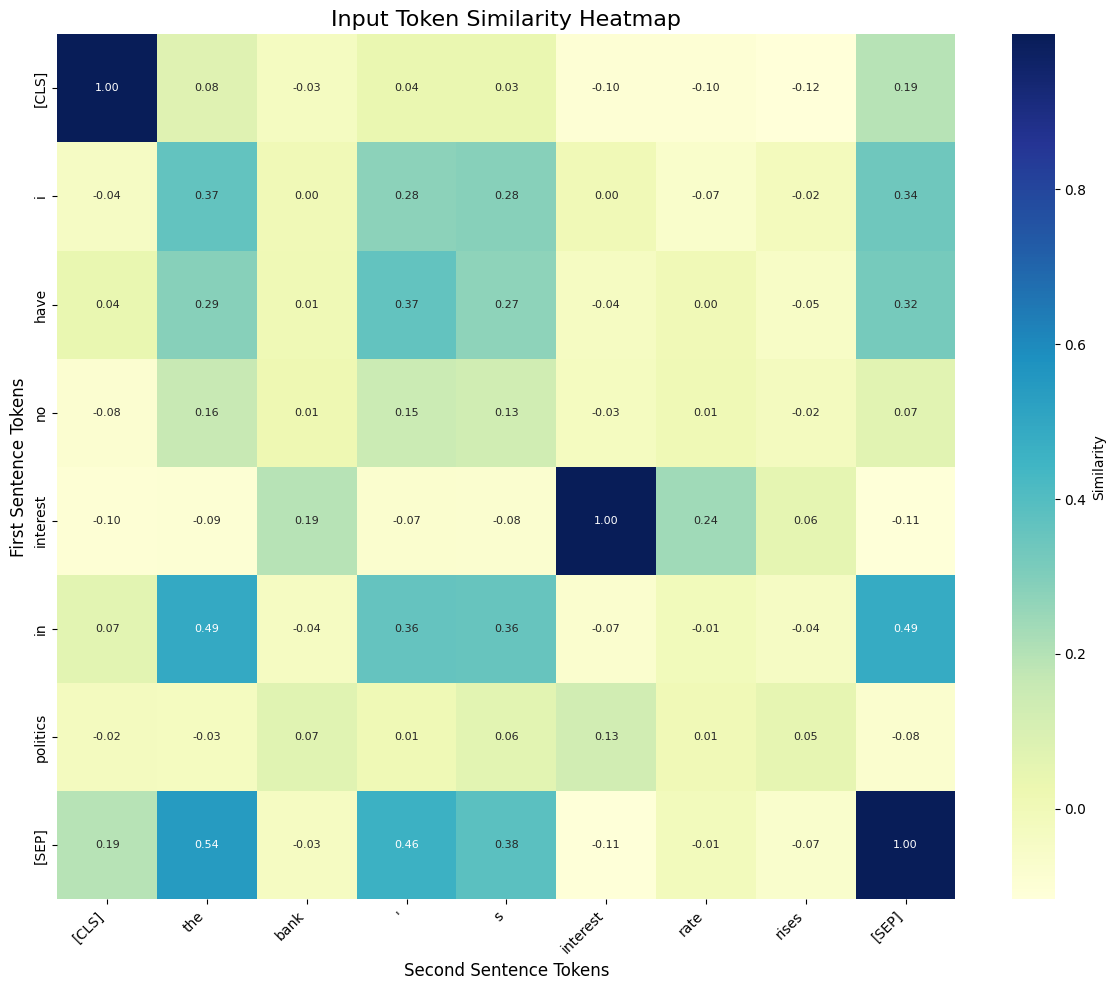

In [19]:
from sentence_transformers import util
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Calculate cosine similarity
distances = util.cos_sim(
    first_embeddings.squeeze(), 
    second_embeddings.squeeze()
).cpu().numpy()

# Get token labels
x_labels = model.tokenizer.convert_ids_to_tokens(second_tokens["input_ids"][0])
y_labels = model.tokenizer.convert_ids_to_tokens(first_tokens["input_ids"][0])

# Create the heatmap using seaborn
plt.figure(figsize=(12, 10))

sns.heatmap(
    distances,
    xticklabels=x_labels,
    yticklabels=y_labels,
    annot=True,
    fmt='.2f',
    cmap='YlGnBu',
    cbar_kws={'label': 'Similarity'},
    annot_kws={'fontsize': 8}
)

plt.xlabel('Second Sentence Tokens', fontsize=12)
plt.ylabel('First Sentence Tokens', fontsize=12)
plt.title('Input Token Similarity Heatmap', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Vocabulary Embedding

As we saw there are 30,522 tokens in the vocabulary, and each token is embedded with a vector of size 384.

In [20]:
token_embeddings = first_module.auto_model \
    .embeddings \
    .word_embeddings \
    .weight \
    .detach() \
    .cpu() \
    .numpy()

print(token_embeddings.shape)

(30522, 384)


### Reduce the embedding vectors to 2D for visualization

We will use the TSNE library to create a 2D visualization of the token embeddings, to allow us to see tokens that are close to one another.

This process can take about a minute or two, based on your CPU.

In [21]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, metric="cosine", random_state=42)
tsne_embeddings_2d = tsne.fit_transform(token_embeddings)
print(tsne_embeddings_2d.shape)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


(30522, 2)


### Token Embedding Visualization

Once we have the 384 dimension reduced to 2D, we can plot it to explore it.

In [22]:
token_colors = []
for token in sorted_tokens:
    if token[0] == "[" and token[-1] == "]": # Control Tokens
        token_colors.append("red")
    elif token.startswith("##"):            # Suffix Tokens
        token_colors.append("blue")
    else:
        token_colors.append("green")        # All Word Tokens

In [ ]:
# !Warning: This cell takes a while to run

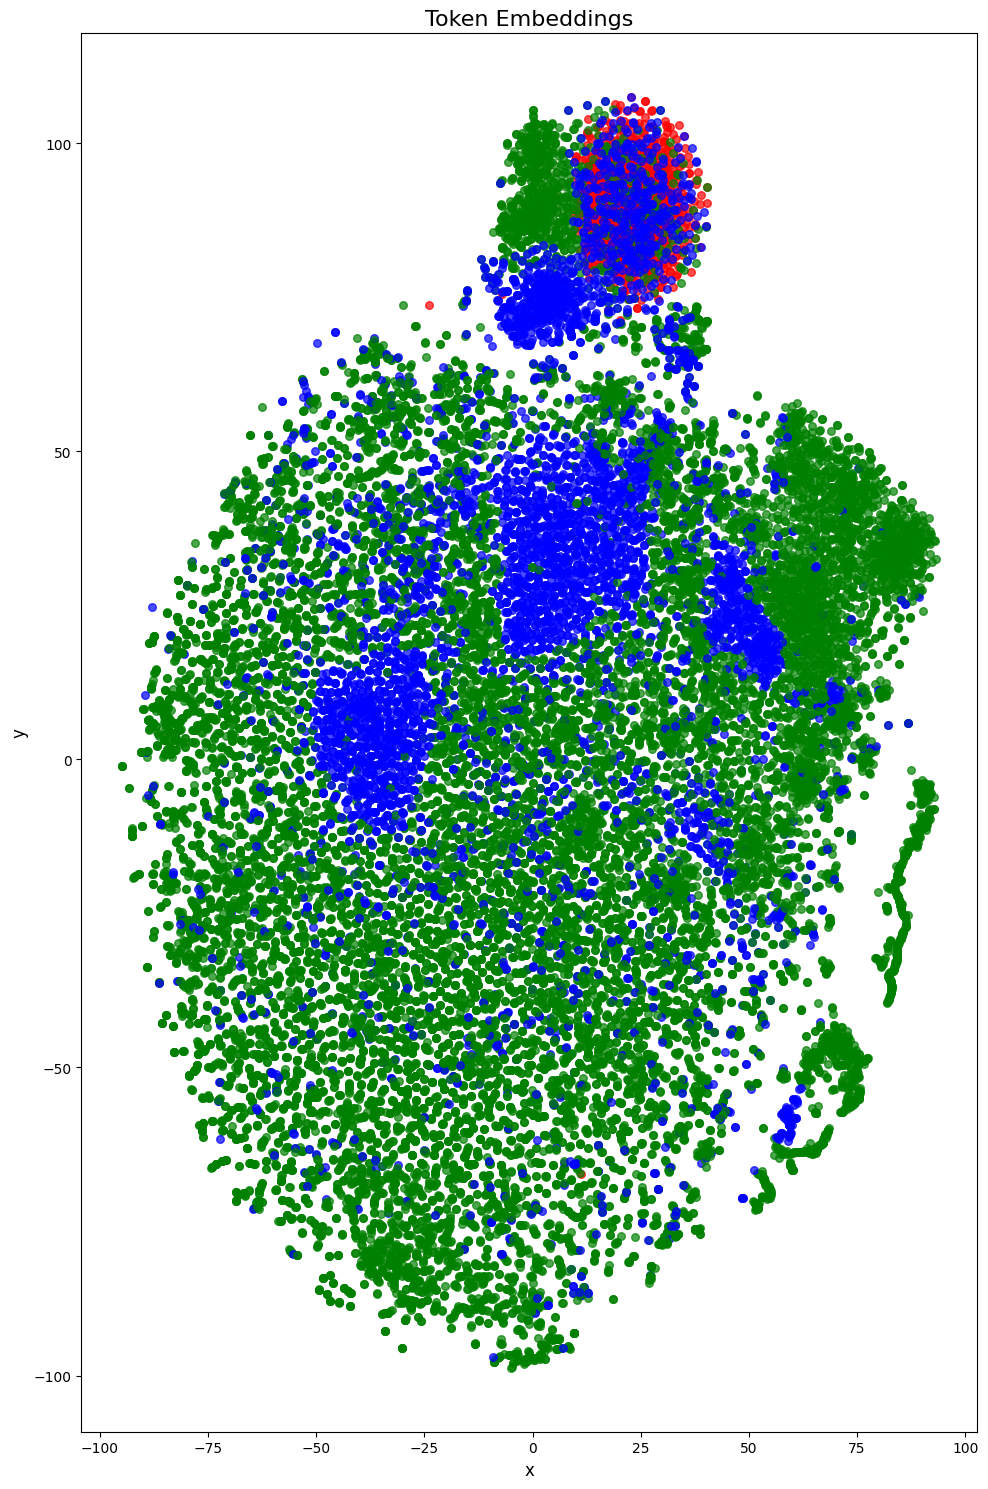

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Create a DataFrame from the data
df = pd.DataFrame({
    'x': tsne_embeddings_2d[:, 0],
    'y': tsne_embeddings_2d[:, 1],
    'token': sorted_tokens,
    'color': token_colors
})

# Create the scatter plot
plt.figure(figsize=(10, 15))

# Use the color column directly without hue
for i, row in df.iterrows():
    plt.scatter(row['x'], row['y'], c=row['color'], s=30, alpha=0.7)

plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title('Token Embeddings', fontsize=16)
plt.tight_layout()
plt.show()

## Open source encoder - output embedding (with context)

Now let's see the token embeddings at the output of the transformer embedding model.

In [24]:
output_embedding = model.encode([first_sentence])
print(output_embedding.shape)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


(1, 384)


In [25]:
output_token_embeddings = model.encode(
    [first_sentence], 
    output_value="token_embeddings"
)
print(output_token_embeddings[0].shape)

torch.Size([8, 384])


In [26]:
with torch.no_grad():
    first_tokens = model.tokenize([first_sentence])
    second_tokens = model.tokenize([second_sentence])
    
    first_output_embeddings = model.encode(
        [first_sentence], 
        output_value="token_embeddings"
    )
    second_output_embeddings = model.encode(
        [second_sentence], 
        output_value="token_embeddings"
    )

# Calculate cosine similarity
distances = util.cos_sim(
    first_output_embeddings[0], 
    second_output_embeddings[0]
)

### Visualize the **Output** Token Similarity

Similar to the way to visualized the similarity of the **Input** tokens from the embedding lookup table, we will visualize the similar of the same tokens from the **Output** of the transformer model, after it applied the positional encoding and the attention layers.

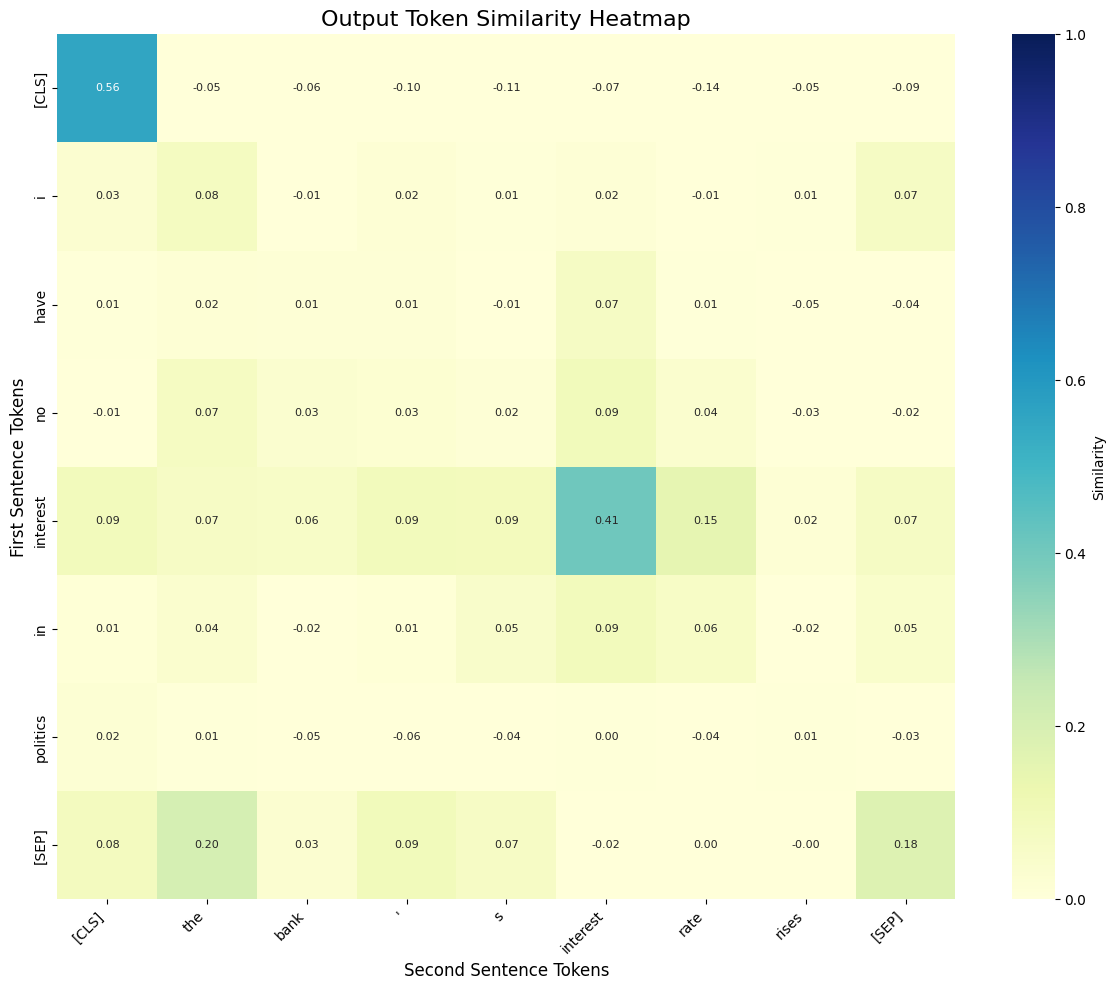

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Get token labels
x_labels = model.tokenizer.convert_ids_to_tokens(second_tokens["input_ids"][0])
y_labels = model.tokenizer.convert_ids_to_tokens(first_tokens["input_ids"][0])

# Create the heatmap using seaborn
plt.figure(figsize=(12, 10))

sns.heatmap(
    distances.cpu().numpy(),
    xticklabels=x_labels,
    yticklabels=y_labels,
    annot=True,
    fmt='.2f',
    cmap='YlGnBu',
    vmin=0,
    vmax=1,
    cbar_kws={'label': 'Similarity'},
    annot_kws={'fontsize': 8}
)

plt.xlabel('Second Sentence Tokens', fontsize=12)
plt.ylabel('First Sentence Tokens', fontsize=12)
plt.title('Output Token Similarity Heatmap', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [28]:
# Calculate cosine distance between output embeddings
from sklearn.metrics.pairwise import cosine_distances

def calculate_sentence_similarity(first_sentence, second_sentence):

    first_embeddings = model.encode([first_sentence])
    second_embeddings = model.encode([second_sentence])

    # Reshape the embeddings to 2D arrays
    first_embedding_2d = first_embeddings.reshape(1, -1)
    second_embedding_2d = second_embeddings.reshape(1, -1)

    # Calculate cosine distance
    cosine_distance = cosine_distances(first_embedding_2d, second_embedding_2d)[0][0]

    # Note: Cosine distance is 1 - cosine similarity
    cosine_similarity = 1 - cosine_distance

    print("First Sentence: ", first_sentence)
    print("Second Sentence: ", second_sentence)
    print("Cosine Distance: ", cosine_distance)
    print("Cosine Similarity: ", cosine_similarity)


In [29]:
calculate_sentence_similarity(first_sentence, second_sentence)

First Sentence:  I have no interest in politics
Second Sentence:  The bank's interest rate rises
Cosine Distance:  0.9384283
Cosine Similarity:  0.061571717


In [30]:
third_sentence = "Chase increased its lending fees"

calculate_sentence_similarity(second_sentence, third_sentence)

First Sentence:  The bank's interest rate rises
Second Sentence:  Chase increased its lending fees
Cosine Distance:  0.5654546
Cosine Similarity:  0.4345454


## Improved encoder for queries and documents (bi-encoder)

We will use [Contextual Document Embeddings (CDE)](https://huggingface.co/jxm/cde-small-v1), which is one of the trending models in the Hugging Face model repository.

In [32]:
import transformers

improved_model = transformers.AutoModel.from_pretrained("jxm/cde-small-v1", trust_remote_code=True)
tokenizer = transformers.AutoTokenizer.from_pretrained("bert-base-uncased")

<All keys matched successfully>
<All keys matched successfully>


In [33]:
print(improved_model)

DatasetTransformer(
  (first_stage_model): BiEncoder(
    (embedder): NomicBertModel(
      (embeddings): NomicBertEmbeddings(
        (word_embeddings): Embedding(30528, 768)
        (token_type_embeddings): Embedding(2, 768)
      )
      (emb_drop): Dropout(p=0.0, inplace=False)
      (emb_ln): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (encoder): NomicBertEncoder(
        (layers): ModuleList(
          (0-11): 12 x NomicBertBlock(
            (attn): NomicBertAttention(
              (rotary_emb): NomicBertRotaryEmbedding()
              (Wqkv): Linear(in_features=768, out_features=2304, bias=False)
              (out_proj): Linear(in_features=768, out_features=768, bias=False)
              (drop): Dropout(p=0.0, inplace=False)
            )
            (mlp): NomciBertGatedMLP(
              (fc11): Linear(in_features=768, out_features=3072, bias=False)
              (fc12): Linear(in_features=768, out_features=3072, bias=False)
              (fc2): Linear(in_fe

In [ ]:
$ datasets==3.6.0 #compatibility issues

In [35]:
from datasets import load_dataset

corpus = load_dataset("BeIR/fiqa", "corpus")["corpus"]
queries = load_dataset("BeIR/fiqa", "queries")["queries"]

### Dataset samples

Let's see some examples of of the [Financial Opinion Mining and Question Answering (FiQA) dataset](https://huggingface.co/datasets/BeIR/fiqa) documents and queries.

In [36]:
for i in range(10):
    print(corpus[i])
    print(queries[i])
    print("-"*100)


{'_id': '3', 'title': '', 'text': "I'm not saying I don't like the idea of on-the-job training too, but you can't expect the company to do that. Training workers is not their job - they're building software. Perhaps educational systems in the U.S. (or their students) should worry a little about getting marketable skills in exchange for their massive investment in education, rather than getting out with thousands in student debt and then complaining that they aren't qualified to do anything."}
{'_id': '0', 'title': '', 'text': 'What is considered a business expense on a business trip?'}
----------------------------------------------------------------------------------------------------
{'_id': '31', 'title': '', 'text': "So nothing preventing false ratings besides additional scrutiny from the market/investors, but there are some newer controls in place to prevent institutions from using them. Under the DFA banks can no longer solely rely on credit ratings as due diligence to buy a finan

## Stage 1: Gather dataset embeddings

CDE works by first getting a set of embeddings from corpus documents that is intended to be representative of the overall corpus. We first sample a number of documents from the corpus (this model is trained with 512 documents from each context) and get their embeddings from our first-stage model.

In [37]:
query_prefix = "search_query: "
document_prefix = "search_document: "

In [38]:
import random

def process_ex_document(ex: dict) -> dict:
  ex["text"] = f"{ex['title']} {ex['text']}"
  return ex

corpus_size = improved_model.config.transductive_corpus_size
print(f"Choosing {corpus_size} out of {len(corpus)} documents")
minicorpus_docs = corpus.select(random.choices(list(range(len(corpus))), k=corpus_size))
minicorpus_docs = minicorpus_docs.map(process_ex_document)["text"]
minicorpus_docs = tokenizer(
    [document_prefix + doc for doc in minicorpus_docs],
    truncation=True,
    padding=True,
    max_length=512,
    return_tensors="pt"
)

Choosing 512 out of 57638 documents


Map: 100%|██████████| 512/512 [00:00<00:00, 6940.49 examples/s]


In [43]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
minicorpus_docs = minicorpus_docs.to(device)
print(device)

cpu


In [44]:
import torch
from tqdm.autonotebook import tqdm

batch_size = 32

dataset_embeddings = []
for i in tqdm(range(0, len(minicorpus_docs["input_ids"]), batch_size)):
    minicorpus_docs_batch = {k: v[i:i+batch_size] for k,v in minicorpus_docs.items()}
    with torch.no_grad():
        dataset_embeddings.append(
            improved_model.first_stage_model(**minicorpus_docs_batch)
        )

dataset_embeddings = torch.cat(dataset_embeddings)

100%|██████████| 16/16 [01:05<00:00,  4.07s/it]


## Stage 2: Embed in context

Now that we have dataset embeddings, we can use them to embed queries and documents like normal. We just need to provide an extra argument (`dataset_embeddings` in the CDE code).

In [45]:
sample_docs = corpus.select(range(16)).map(process_ex_document)["text"]

docs_tokens = tokenizer(
    [document_prefix + doc for doc in sample_docs],
    truncation=True,
    padding=True,
    max_length=512,
    return_tensors="pt"
).to(device)

with torch.no_grad():
  doc_embeddings = improved_model.second_stage_model(
      input_ids=docs_tokens["input_ids"],
      attention_mask=docs_tokens["attention_mask"],
      dataset_embeddings=dataset_embeddings,
  )
doc_embeddings /= doc_embeddings.norm(p=2, dim=1, keepdim=True)

In [46]:
queries_sample = queries.select(range(16))["text"]
queries_tokens = tokenizer(
    [query_prefix + query for query in queries_sample],
    truncation=True,
    padding=True,
    max_length=512,
    return_tensors="pt"
).to(device)

with torch.no_grad():
  query_embeddings = improved_model.second_stage_model(
      input_ids=queries_tokens["input_ids"],
      attention_mask=queries_tokens["attention_mask"],
      dataset_embeddings=dataset_embeddings,
  )
query_embeddings /= query_embeddings.norm(p=2, dim=1, keepdim=True)

### Models Comparison

Let's compare the two models (basic and improved with context) on the samples of the documents and queries.

In [47]:
with torch.no_grad():
  doc_basic_embeddings = model.encode(sample_docs)


In [48]:
with torch.no_grad():
  queries_basic_embeddings = model.encode(queries_sample)

Embedding Model Comparison


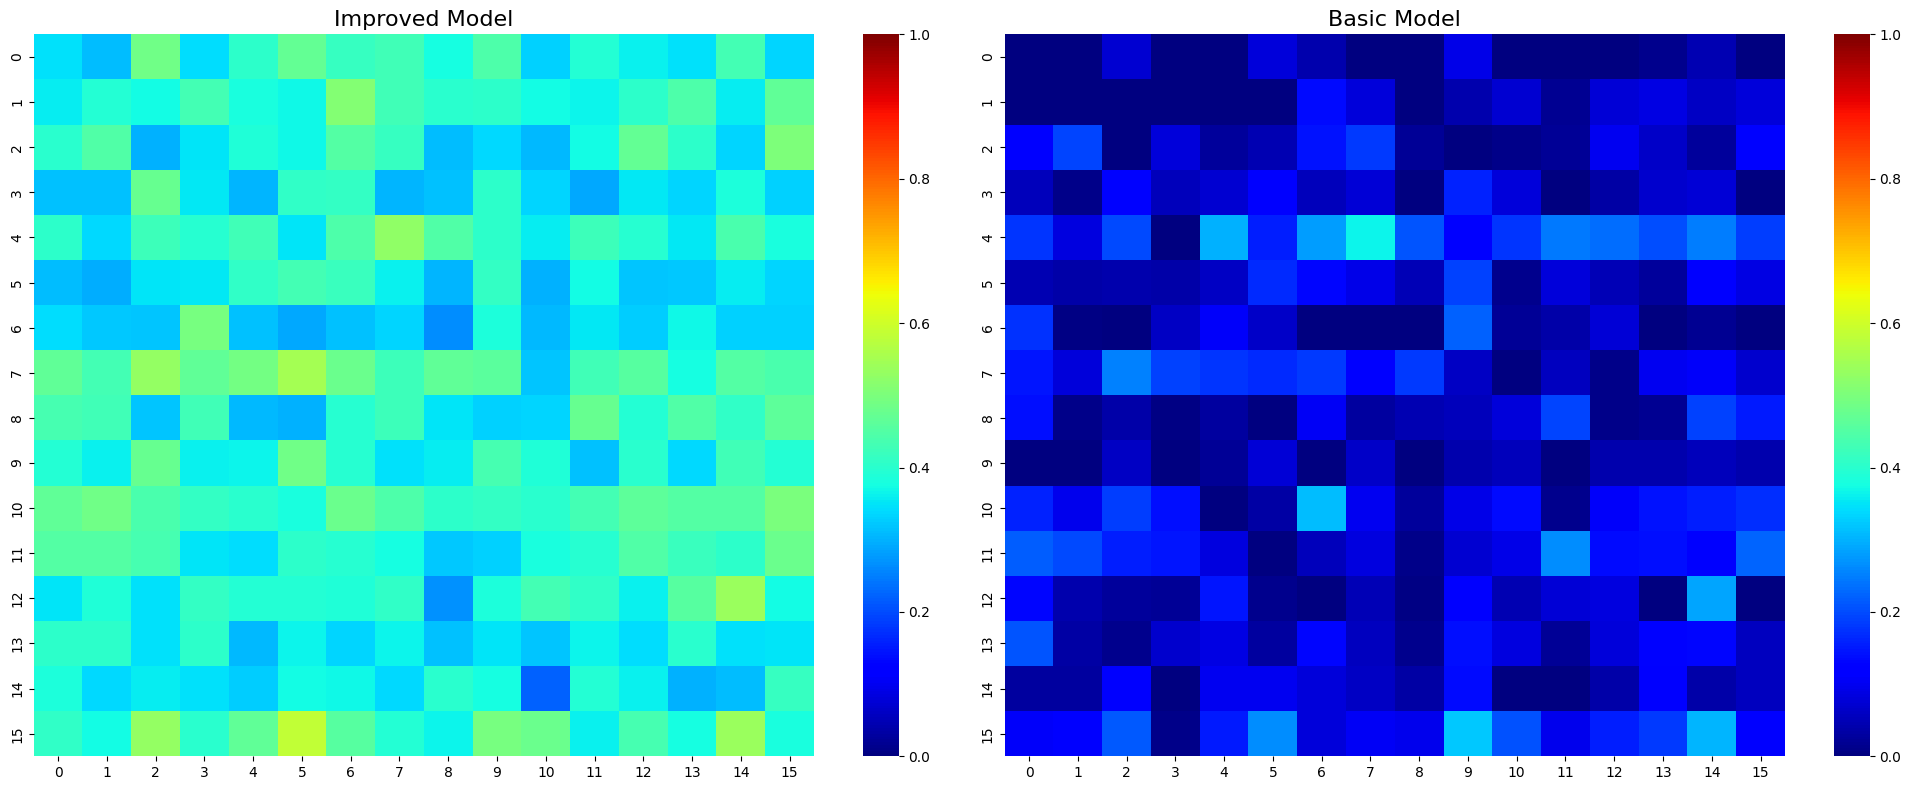

In [49]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Heatmap for improved model
sns.heatmap((doc_embeddings @ query_embeddings.T).cpu(), cmap="jet", ax=ax1, vmin=0, vmax=1)
ax1.set_title("Improved Model", fontsize=16)

# Heatmap for basic model
sns.heatmap((doc_basic_embeddings @ queries_basic_embeddings.T), cmap="jet", ax=ax2 ,vmin=0, vmax=1)
ax2.set_title("Basic Model", fontsize=16)

plt.tight_layout()
print("Embedding Model Comparison")
plt.show()

# Other Types of Embeddings

In [51]:
from dotenv import load_dotenv
from langchain_qdrant import FastEmbedSparse, RetrievalMode, QdrantVectorStore
from langchain_huggingface import HuggingFaceEmbeddings

load_dotenv()

True

In [52]:
from langchain_community.document_loaders import PyPDFLoader
from dotenv import load_dotenv

load_dotenv()

file_path = (
    "data/visual_instruction_tunning.pdf"
)
loader = PyPDFLoader(file_path)
docs = loader.load_and_split()

In [53]:
docs

[Document(metadata={'producer': 'pdfTeX-1.40.25', 'creator': 'LaTeX with hyperref', 'creationdate': '2023-12-14T01:02:53+00:00', 'author': '', 'keywords': '', 'moddate': '2023-12-14T01:02:53+00:00', 'ptex.fullbanner': 'This is pdfTeX, Version 3.141592653-2.6-1.40.25 (TeX Live 2023) kpathsea version 6.3.5', 'subject': '', 'title': '', 'trapped': '/False', 'source': 'data/visual_instruction_tunning.pdf', 'total_pages': 25, 'page': 0, 'page_label': '1'}, page_content='Visual Instruction Tuning\nHaotian Liu1∗, Chunyuan Li2∗, Qingyang Wu3, Yong Jae Lee1\n1University of Wisconsin–Madison 2Microsoft Research 3Columbia University\nhttps://llava-vl.github.io\nAbstract\nInstruction tuning large language models (LLMs) using machine-generated\ninstruction-following data has been shown to improve zero-shot capabilities on\nnew tasks, but the idea is less explored in the multimodal field. We present the\nfirst attempt to use language-only GPT-4 to generate multimodal language-image\ninstruction-foll

## Sparse embeddings

- Sparse embeddings are high-dimensional vectors, where most elements are zero, and only a few dimensions hold non-zero values. They are often derived from traditional methods like TF-IDF or BM25, focusing on specific keywords or tokens present in the text. In the context of RAG, sparse embeddings help match documents and queries based on exact term overlap rather than broader semantic relationships.

In [75]:
from pprint import pprint

In [55]:
sparse_embeddings = FastEmbedSparse(model_name="Qdrant/bm25")

Fetching 18 files: 100%|██████████| 18/18 [00:00<00:00, 20.62it/s]


In [ ]:
from fastembed.sparse.bm25 import Bm25

bm25_embedding_model = Bm25("Qdrant/bm25")
bm25_embeddings = list(bm25_embedding_model.embed(docs[0].page_content))
bm25_embeddings

In [77]:
sparse_embeddings_model = FastEmbedSparse(model_name="Qdrant/bm25")
sparse_embeddings = sparse_embeddings_model.embed_query(docs[0].page_content)
sparse_embeddings

SparseVector(indices=[2006536704, 1709076482, 1208116226, 119152643, 939215365, 984524805, 769443847, 1265401351, 917314569, 1010544659, 332723732, 301030427, 2129237020, 440359455, 1602970658, 209724451, 1135884324, 307881509, 520409122, 1763574823, 236277287, 548814886, 521663532, 498297388, 73978416, 722829366, 243669559, 2091876921, 34379837, 1684568639, 1556425280, 1691351615, 2035334722, 1690985542, 237251143, 1237113930, 930102859, 1732471882, 1734550606, 286434387, 1889686612, 2061629524, 1047788632, 1778032728, 2024122462, 1795282015, 1096710751, 2032101475, 2016898148, 395514983, 573216872, 1026658409, 751565418, 2135545454, 2061075054, 976803442, 1892845683, 1452893298, 124635254, 1198767231, 358389376, 1391213695, 1481341055, 258304643, 738409095, 238865545, 2063746700, 683845261, 749129358, 917062287, 1012568720, 1366453392, 1019123853, 1457778837, 1806665370, 1583132830, 866531999, 2035475614, 1348598945, 613148321, 192365738, 1479387819, 1104645803, 924356269, 839500970,

## Late interaction embeddings

- Late interaction embeddings refer to a hybrid approach where sparse and dense embeddings are combined during the retrieval process, but their interactions are delayed until the final ranking or matching phase. This allows the model to first retrieve candidates based on simpler, faster methods and then refine the ranking through more complex, dense representations. In RAG, this helps improve retrieval quality while balancing computational efficiency.

In [78]:
from fastembed.late_interaction import LateInteractionTextEmbedding

late_interaction_embedding_model = LateInteractionTextEmbedding("colbert-ir/colbertv2.0")
late_interaction_embeddings = list(late_interaction_embedding_model.passage_embed(docs[0].page_content))
len(late_interaction_embeddings[0])

Fetching 5 files: 100%|██████████| 5/5 [00:08<00:00,  1.71s/it]


415

In [79]:
late_interaction_embeddings

[array([[-0.04882313,  0.119225  , -0.01285574, ...,  0.30301428,
          0.07750032,  0.10142803],
        [-0.07576274,  0.05411925,  0.06219344, ...,  0.19690388,
          0.02341153,  0.1082113 ],
        [ 0.09570188,  0.01837038,  0.02766534, ...,  0.11542836,
          0.19693974,  0.08702882],
        ...,
        [-0.01454361, -0.00655604,  0.02537229, ...,  0.22611995,
          0.06020958,  0.0911296 ],
        [-0.03725345, -0.02597386,  0.02905554, ...,  0.12952738,
          0.06560779,  0.01749112],
        [-0.03752655,  0.0468375 , -0.04868479, ...,  0.2454249 ,
          0.06264785,  0.10226648]], shape=(415, 128), dtype=float32)]

In [80]:
late_interaction_embeddings[0].size

53120